## [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST)

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [2]:
import os
import random
import numpy as np
import torch
import torchvision

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
dataset = torchvision.datasets.FashionMNIST('./data', download=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 108762522.42it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 7623307.01it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 61553196.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22100590.58it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
print(type(dataset))

# tuple: (image, target)

<class 'torchvision.datasets.mnist.FashionMNIST'>


In [ ]:
print(len(dataset))

60000


In [ ]:
n = 200
data, target = dataset[n]

In [ ]:
print(type(data))

<class 'PIL.Image.Image'>


In [ ]:
print(data.mode, data.width, data.height)

L 28 28


In [ ]:
print(type(target))

<class 'int'>


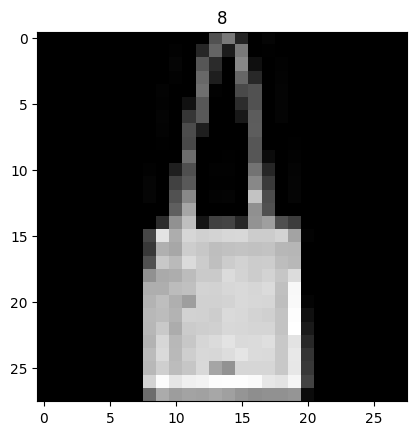

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title(target)
plt.imshow(data, cmap='gray')
data.show()

In [ ]:
import torchvision.transforms as transforms
# batch must contain tensors, numpy arrays, numbers, dicts or lists
ToTensor = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.FashionMNIST('./data', transform = ToTensor)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1,
                                          shuffle=True)

torch.Size([1, 1, 28, 28])
torch.Size([28, 28])


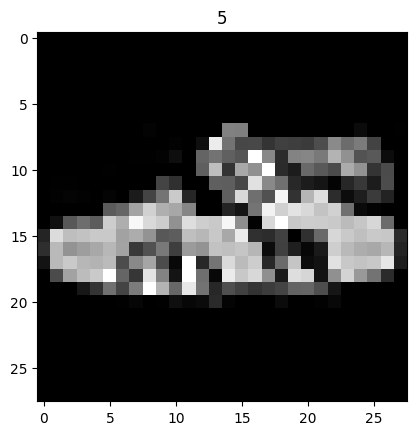

In [ ]:
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in data_loader:
    print(data.shape)
    data = data.squeeze() # 불필요한 차원 하나를 줄인다(batch_size=1)
    data = data.squeeze() # 불필요한 차원 하나를 줄인다(color)
    print(data.shape)
    pic = ToPILImage(data)
    plt.title(int(target))
    plt.imshow(pic, cmap='gray')
    plt.show()
    break

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=10,
                                          shuffle=True)

torch.Size([10, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([28, 28])


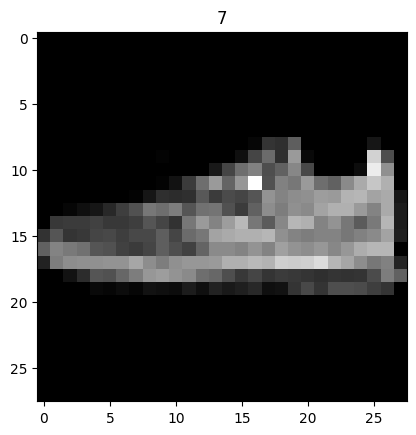

In [ ]:
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in data_loader:
    index = 5
    print(data.shape)
    img = data[index]
    print(img.shape)
    img = img[0] 
    print(img.shape)
    pic = ToPILImage(img)
    plt.title(int(target[index]))
    plt.imshow(img, cmap='gray')
    plt.show()
    break

In [6]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [7]:
print(is_cuda, device)

True cuda


In [8]:
import torchvision.transforms as transforms
compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

train_data = torchvision.datasets.FashionMNIST(root='./data/', train=True, transform=compose, download=True)
test_data  = torchvision.datasets.FashionMNIST(root='./data/', train=False, transform=compose, download=True)

In [9]:
print('train sets: {}'.format(len(train_data)))
print('test sets: {}'.format(len(test_data)))

train sets: 60000
test sets: 10000


In [10]:
train_batch_size = 64
test_batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=train_batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=test_batch_size,
                                          shuffle=True)

In [11]:
class FashionMNISTModel(nn.Module):
    def __init__(self, output_size):
        super(FashionMNISTModel, self).__init__() # (n, 1, 28, 28)
        self.cv = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 1 = input channel size(gray), 3 = output(filter) volume size (n, 8, 26, 26)
                                              # padding = 0, stride = (1, 1)
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (n, 10, 10, 10)
                nn.ReLU(),
                nn.MaxPool2d(2), # (n, 10, 5, 5)
                nn.Dropout()
        )

        self.fc = nn.Sequential(nn.Linear(64 * 7 * 7, 128),
                                nn.ReLU(),
                                nn.Linear(128, 10)
              )        
        
    def forward(self, x):
        x = self.cv(x)
        x = x.view(-1, 64*7*7)
        output = self.fc(x)
        with torch.no_grad():
            value = torch.max(output, 1)[1]
        return output, value

In [12]:
model = FashionMNISTModel(10).to(device)

In [13]:
n = 0
for data, target in train_loader:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y, _ = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([64, 1, 28, 28])
tensor([[-1.7361e-01, -1.8985e-02,  7.8180e-03,  4.9289e-02,  1.4415e-01,
         -1.5418e-01, -7.5519e-02, -4.7173e-02, -3.7705e-02, -1.5583e-01],
        [ 4.8331e-02, -4.4130e-02, -6.4033e-04,  8.3225e-02,  8.1940e-02,
         -7.6840e-02, -8.3536e-02, -6.5396e-02,  8.4720e-02, -1.6353e-01],
        [ 2.1797e-02, -5.9680e-02, -2.5615e-02,  8.1931e-02, -3.1977e-02,
         -5.9173e-02, -3.0456e-02, -5.4947e-03,  1.1228e-01, -1.8674e-01],
        [-6.1660e-02, -1.0842e-01, -1.1955e-01,  4.0701e-02,  7.7748e-03,
         -3.3230e-02, -5.3297e-02,  1.5995e-02,  4.5853e-02, -2.3028e-01],
        [ 5.4504e-02, -1.5580e-01, -2.4033e-02,  9.4195e-02, -2.6743e-02,
          4.1630e-02,  3.4607e-02,  3.7194e-02,  4.5765e-02, -1.4060e-01],
        [-7.3941e-02, -1.3654e-01, -1.4217e-01,  1.8342e-01,  4.3862e-02,
         -2.4070e-02,  1.4852e-02,  1.3430e-02,  7.7032e-03, -1.7142e-01],
        [-3.6020e-02, -7.9177e-02, -3.1098e-02,  4.6351e-02,  1.2372e-02,
    

In [14]:
BATCH_SIZE = 1000

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [15]:
model = FashionMNISTModel(10).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 10 # 10회 학습

list_training_loss = []
list_test_loss = []

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0
    model.train()
    for train_data, train_target in train_loader:
        train_data = train_data.to(device)
        train_target = train_target.to(device)
        y, _ = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        del train_target
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += 1

    model.eval()
    n_test = 0
    test_loss = 0
    for test_data, test_target in test_loader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred, _ = model(test_data)
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1

    print('epoch {}th training loss: {} test loss: {}'.format(epoch, train_loss / n_train, test_loss / n_test))
    list_training_loss.append(train_loss / n_train)
    list_test_loss.append(test_loss / n_test)

epoch 0th training loss: 0.7660270075003306 test loss: 0.4804184377193451
epoch 1th training loss: 0.4482706680893898 test loss: 0.4025223821401596
epoch 2th training loss: 0.38988309502601626 test loss: 0.3617836594581604
epoch 3th training loss: 0.3569592510660489 test loss: 0.3440997153520584
epoch 4th training loss: 0.333283805847168 test loss: 0.3200559586286545
epoch 5th training loss: 0.3152423312266668 test loss: 0.30815639197826383
epoch 6th training loss: 0.3012161115805308 test loss: 0.2988267242908478
epoch 7th training loss: 0.28452338924010595 test loss: 0.2817095547914505
epoch 8th training loss: 0.27596019580960274 test loss: 0.27758677005767823
epoch 9th training loss: 0.2650264841814836 test loss: 0.2706000000238419


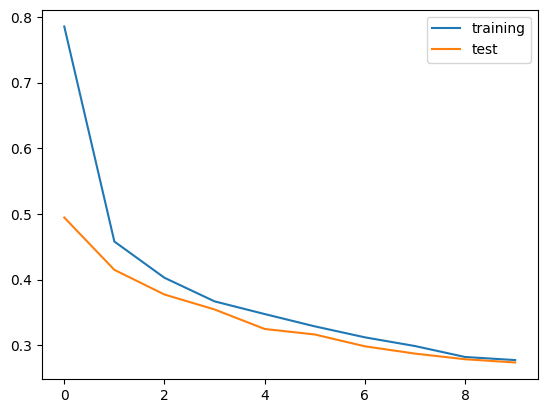

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

model.eval()
y_test = None
y_pred = None
for test_data, test_target in test_loader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    _, y = model(test_data)
    del test_data
    if None == y_test:
        y_test = test_target
    else:
        torch.cat([y_test, test_target], dim=0)
    if None == y_pred:
        y_pred = y
    else:
        torch.cat([y_pred, y], dim=0)

score = accuracy_score(y_test.cpu(), y_pred.cpu())
print(score)

0.904
